<a href="https://colab.research.google.com/github/nedelculiviu95/cnn-detecting-lung-opacities/blob/master/CheXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pydicom
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import pylab
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os
import pydicom
from skimage import measure
from skimage.transform import resize
from tensorflow import keras
import keras
import csv
from keras.callbacks import *
from os.path import isfile, join

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 7.0MB 3.5MB/s 


Using TensorFlow backend.


In [0]:
LR = 0.001
EPOCHS = 20
BATCHSIZE = 16
CHANNELS = 64
IMAGE_SIZE = 299
NBLOCK = 6 
MOMENTUM = 0.9
DIMS = (IMAGE_SIZE,IMAGE_SIZE,3)

In [0]:
images1_folder = "/content/gdrive/My Drive/images1/"
images3_folder = "/content/gdrive/My Drive/images/"
filenames_3 = [f for f in os.listdir(images3_folder) if isfile(join(images3_folder, f))]
filenames_1 = [f for f in os.listdir(images1_folder) if isfile(join(images1_folder, f))]

train_filenames = []
folder = "/content/gdrive/My Drive/data_filenames/train.txt"
file1 = open(folder, "r") 
for line in file1: 
  l = line[0:16]
  train_filenames.append(l)
file1.close()

print('n train samples', len(train_filenames))

test_filenames = []
folder = "/content/gdrive/My Drive/data_filenames/test.txt"
file1 = open(folder, "r") 
for line in file1: 
  l = line[0:16]
  test_filenames.append(l)
file1.close()

print('n test samples', len(test_filenames))

valid_filenames = []
folder = "/content/gdrive/My Drive/data_filenames/validation.txt"
file1 = open(folder, "r") 
for line in file1: 
  l = line[0:16]
  valid_filenames.append(l)
file1.close()

print('n validation samples', len(valid_filenames))


n train samples 11665
n test samples 2729
n validation samples 1500


In [0]:
def diseases_breakdown(parsed, filenames):
  dictionary = {'Atelectasis': 0, 'Cardiomegaly': 0, 'Effusion': 0, 'Infiltration':0, 
                'Mass': 0, 'Nodule': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Consolidation': 0,
               'Edema':0, 'Emphysema':0, 'Fibrosis': 0, 'Pleural_Thickening': 0, 'Hernia': 0, 'No Finding': 0}
  for fil in filenames:
    labels = parsed[fil]['label']
    
    for l in labels:
      dictionary[l] += 1
  
  return dictionary

def disease_table(dictionary, filenames, dataset_type):
  total = 0
  ratio_list = []
  print("Total",dataset_type,": ",len(filenames))
  print("---------------------------------")
  for key,value in dictionary.items():
    ratio = value / len(filenames)
    ratio_list.append(ratio)
    print(key,":",value, "      Ratio: ", ratio)
  print()
  return ratio_list

def parse_data(df):
    """
    Read DataEntry2017 CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'image-name01': {
            'png': path/to/png/file,
            'label': list of labels, 
            'patient_gender': M or F
            'pattient_age': int
        },
        'image-name-02': {
            'png': path/to/png/file,
            'label': list of labels,
            'patient_gender': M or F
            'pattient_age': int
        }, ...

      }
      
    """
    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['Image Index']
        if pid not in parsed:
            labels = row['Finding Labels']
            parsed[pid] = {
                'png': '%s' % pid,
                'label': labels.split("|"),
                'patient_gender': row['Patient Gender'],
                'pattient_age': row['Patient Age']}
        
        #labels = row['Finding Labels']
        #parsed[pid]['label'].append(labels.split("|"))
        
    return parsed
  
  
df = pd.read_csv('/content/gdrive/My Drive/ChestXRay_csv/Data_Entry_2017.csv')
parsed = parse_data(df)


In [0]:
vv = valid_filenames
to_remove = 70
for f in vv:
  ll = parsed[f]['label']
  if "Emphysema" in ll or  "Fibrosis" in ll:
    vv.remove(f)
    to_remove -= 1
    if to_remove == 0:
      break

dd = diseases_breakdown(parsed, vv)
validation_ratio_list = disease_table(dd, vv, "validation data")

valid_filenames = vv
print(len(valid_filenames))

to_remove = 80
for f in vv:
  ll = parsed[f]['label']
  if "Effusion" in ll:
    vv.remove(f)
    to_remove -= 1
    if to_remove == 0:
      break

dd = diseases_breakdown(parsed, vv)
validation_ratio_list = disease_table(dd, vv, "validation data")

to_remove = 50
for f in vv:
  ll = parsed[f]['label']
  if "No Finding" in ll:
    vv.remove(f)
    to_remove -= 1
    if to_remove == 0:
      break

dd = diseases_breakdown(parsed, vv)
validation_ratio_list = disease_table(dd, vv, "validation data")
valid_filenames = vv


Total validation data :  1430
---------------------------------
Atelectasis : 136       Ratio:  0.0951048951048951
Cardiomegaly : 94       Ratio:  0.06573426573426573
Effusion : 202       Ratio:  0.14125874125874127
Infiltration : 232       Ratio:  0.16223776223776223
Mass : 57       Ratio:  0.03986013986013986
Nodule : 52       Ratio:  0.03636363636363636
Pneumonia : 16       Ratio:  0.011188811188811189
Pneumothorax : 50       Ratio:  0.03496503496503497
Consolidation : 57       Ratio:  0.03986013986013986
Edema : 32       Ratio:  0.022377622377622378
Emphysema : 21       Ratio:  0.014685314685314685
Fibrosis : 19       Ratio:  0.013286713286713287
Pleural_Thickening : 49       Ratio:  0.03426573426573427
Hernia : 15       Ratio:  0.01048951048951049
No Finding : 756       Ratio:  0.5286713286713287

1430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


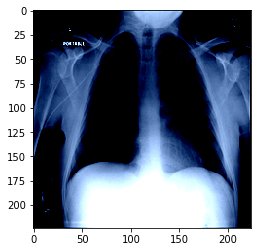

In [0]:
##plot image
from PIL import Image, ImageFile
import matplotlib.image as mpimg

img_path = os.path.join(images1_folder, filenames_1[1])
img = Image.open(img_path).convert("RGB")
#img_arr = np.asarray(img)
#img_arr = img_arr.astype(np.float32)
#img_arr = img_arr / 255.
img_arr = img.resize((224,224), Image.ANTIALIAS)
img_arr = np.asarray(img_arr)
img_arr = img_arr.astype(np.float64)
img_arr = img_arr / 255.

mean = np.array([0.485, 0.456, 0.406 ])
std = np.array([0.229, 0.224, 0.225 ])
img_arr = img_arr - mean
img_arr = img_arr / std
#img_arr = np.fliplr(img_arr)
imgplot = plt.imshow(img_arr)
print(img_arr.shape)


In [0]:
def concrete_labels(parsed, filenames):
  n_labels = 14
  labels_array = np.zeros((len(filenames), n_labels), dtype=int) #4999 x 14
  dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
               'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
  i = 0
  for item in filenames:
    diseases = parsed[item]['label']
    for d in diseases:
      if d == 'No Finding':
        pass
      else:
        j = dictionary[d]
        labels_array[i][j] = 1
    i += 1
  return labels_array

def get_label(filename, parsed):
  n_labels = 14
  label_array = np.zeros((n_labels), dtype=np.uint8) #1 x 14
  dictionary = {'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltration':3, 
                'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7, 'Consolidation': 8,
               'Edema':9, 'Emphysema':10, 'Fibrosis': 11, 'Pleural_Thickening': 12, 'Hernia': 13}
  diseases = parsed[filename]['label']
  for d in diseases:
      if d == 'No Finding':
        pass
      else:
        j = dictionary[d]
        label_array[j] = 1
  return label_array

yy = get_label('00000013_027.png', parsed)
print(yy)
print(type(yy))

[0 1 1 0 1 0 0 0 0 0 1 0 0 0]
<class 'numpy.ndarray'>


In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, state, folder, filenames, parsed, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.state = state
        self.folder = folder
        self.filenames = filenames
        self.parsed = parsed
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def __load__(self, filename):
      
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        img_arr = img_arr / 255.  
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        #horizontal flip
        if self.augment and self.state % 2 == 0:
            img_arr = np.fliplr(img_arr)
        #label of img
        self.state += 1
        label = get_label(filename, self.parsed)
        return img_arr, label
      
    def __loadpredict__(self, filename):
        # load png file as numpy array
        img_path = os.path.join(self.folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.asarray(img)
        img_arr = resize(img_arr, (self.image_size, self.image_size), mode='reflect')
        img_arr = img_arr / 255.  
        mean = np.array([0.485, 0.456, 0.406 ])
        std = np.array([0.229, 0.224, 0.225 ])
        img_arr = img_arr - mean
        img_arr = img_arr / std
        
        return img_arr
      
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # for predict generator
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            imgs = np.array(imgs)
            return imgs
          
            #for evaluate generator
            #items = [self.__load__(filename) for filename in filenames]
            #imgs, labels = zip(*items)
            # create numpy batch
            #imgs = np.array(imgs)
            #labels = np.array(labels)
            #return imgs, labels
        # # train mode: return images and labels and random fliiping
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, labels = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            labels = np.array(labels)
            
            return imgs, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Basic model

In [0]:
from keras.applications.densenet import DenseNet201

base_model = DenseNet201(input_shape=DIMS, weights='imagenet', include_top = False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
#x = keras.layers.BatchNormalization(momentum = MOMENTUM)(x)
# and a logistic layer -- let's say we have 2 classes
x = Dense(14, activation='linear')(x)
predictions = Dense(14, activation='sigmoid')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/

In [0]:
# loss function
def unweighted_binary_crossentropy(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred))
ImageFile.LOAD_TRUNCATED_IMAGES = True
state = 1
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0.000001)

model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=unweighted_binary_crossentropy, metrics=['accuracy'])

checkpoint_path="/content/gdrive/My Drive/improv_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')

train_gen = generator(state, images3_folder, train_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(state, images1_folder, valid_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

In [0]:
history1 = model.fit_generator(train_gen, validation_data=valid_gen, 
                              epochs=EPOCHS, shuffle=True, callbacks=[reduce_lr, checkpoint], verbose=1)
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/improv_weights/model_16_01_linear.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/improv_weights/model_16_01_linear.h5")
print("Saved model to disk")

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('/content/gdrive/My Drive/improv_weights/1.pdf')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('/content/gdrive/My Drive/improv_weights/2.pdf')
plt.show()


In [0]:
from keras.models import model_from_json

# load json and create model
#json_file = open('/content/gdrive/My Drive/16_01/model_16_01_linear.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("/content/gdrive/My Drive/improv_weights/weights.13-38.049.hdf5")
print("Loaded model from disk")
model.compile(optimizer=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999),
              loss=unweighted_binary_crossentropy, metrics=['accuracy'])
print("Compile model from disk")

Loaded model from disk
Compile model from disk


In [0]:
state = 1
test_generator = generator(state, images1_folder, test_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, augment=False, predict=True)
test_labels = concrete_labels(parsed, test_filenames)
test = model.evaluate_generator(test_generator, verbose=1)
print("Loss and Accuracy: ", test)

# -------- Get the predictions of the testing data----------
state = 0
test_generator = generator(state, images1_folder, test_filenames, parsed, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=True)
test_pred = model.predict_generator(test_generator, verbose=1)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


171/171 [==============================] - 873s 5s/step
Loss and Accuracy:  [42.566004503249424, 0.2099670209195335]


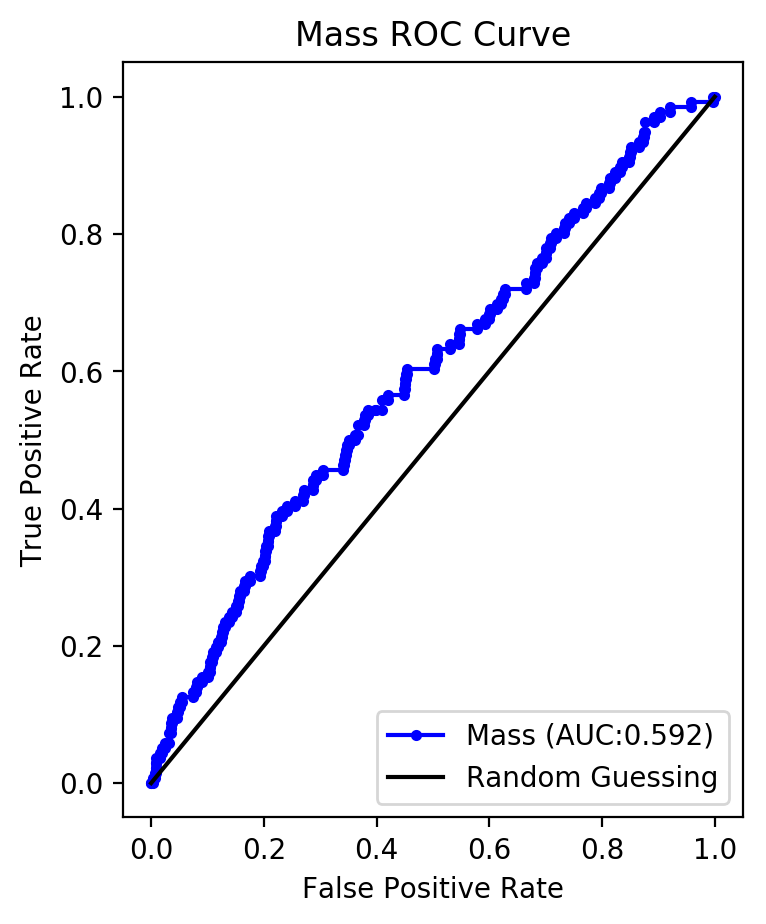

In [0]:
test_labels = concrete_labels(parsed, test_filenames)
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_labels[:,4], test_pred[:,4], pos_label=1)
fig, ax1 = plt.subplots(1,1, figsize = (4, 5), dpi = 200)
ax1.plot(fpr, tpr, 'b.-', label = 'Mass (AUC:%2.3f)' % roc_auc_score(test_labels[:,4], test_pred[:,4], average='micro'))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Mass ROC Curve')
fig.savefig('roc_valid.pdf')

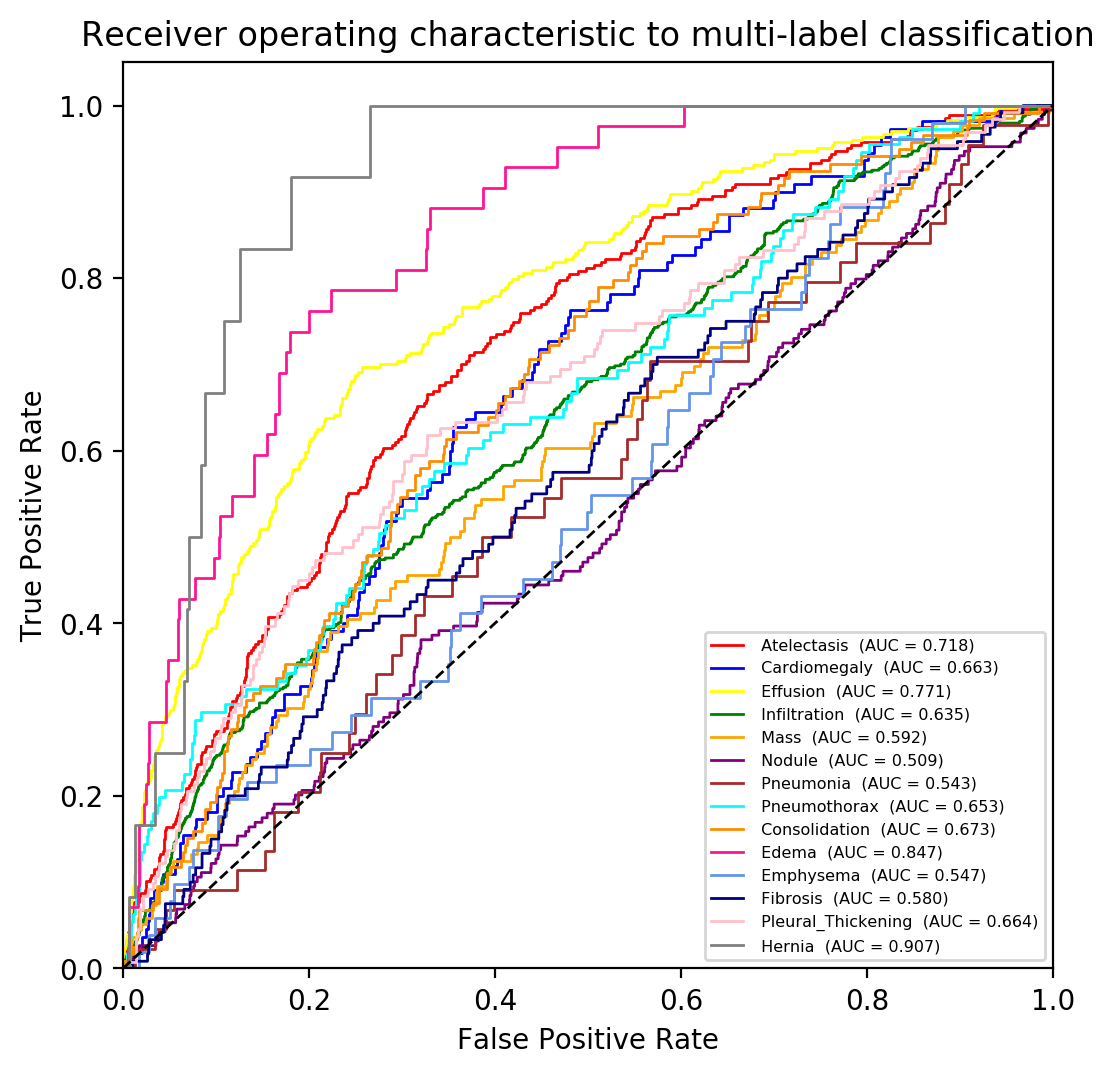

In [0]:
from itertools import cycle
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score

figure(num=None, figsize=(6, 6), dpi=200, facecolor='w', edgecolor='k')
lw = 1
average_auc_score = 0

labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
              'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
              'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

colors = cycle(['red','blue','yellow','green', 'orange','purple','brown','aqua','darkorange','deeppink','cornflowerblue','navy', 'pink', 'grey' ])
for i, color in zip(range(14), colors):
  fpr, tpr, _ = roc_curve(test_labels[:,i], test_pred[:,i], pos_label=1)
  average_auc_score += metrics.auc(fpr,tpr)
  plt.plot(fpr, tpr, color=color, lw=lw,
           label=' {0}  (AUC = {1:0.3f})'
           ''.format(labels[i], metrics.auc(fpr,tpr)))

  
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-label classification')
plt.legend(loc="lower right",fontsize="xx-small")
plt.show()

In [0]:
print("AVERAGE AUC SCORE: ", average_auc_score/14)

AVERAGE AUC SCORE:  0.6644169978794429


#Observations
- Using learning rate decay of 0.1 when validation loss plateus after each epoch is way better
- Using 50% horizontal flip results in less overfitting, lower validation loss and higher validation accuracy
- Increasing the accuracy does not mean an increasing of the AUROC performnace per class of the model
- Lower val loss results in a higher AUC per class
- improved model with 902 image size does not increase the AUC even if the validation loss has decreased
- increasing the batch size on the base model will increase the training and validation loss, the accuracy is very similar

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, Lr=0.0001
- AVERAGE AUC SCORE:  0.6793138036512697
- Loss and Accuracy:  [42.566004503249424, 0.2099670209195335]
- val_loss: 38.0416 - val_acc: 0.2068

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, Lr=0.001
- Loss and Accuracy:  Loss and Accuracy:  [41.14012947515849, 0.31953096372843576]
- val_loss: 37.3063 - val_acc: 0.3140
- AVERAGE AUC SCORE: 0.7139104183426649

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, Lr=0.01
- Loss and Accuracy:  [43.93707524205617, 0.1758886038869368]
- val_loss: 75.9204 - val_acc: 0.2227
- AVERAGE AUC SCORE:  0.615160225297636

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, batch size = 32
- Loss and Accuracy: [41.99845891262682, 0.23928178821172677]
- val_loss: 75.9204 - val_acc: 0.2227
- AVERAGE AUC SCORE: 0.6887897875376442

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, batch size = 8
- Loss and Accuracy:  [23.05044005056055, 0.32685965555148405]
- val_loss: 20.2697 - val_acc: 0.3218
- AVERAGE AUC SCORE:  0.6490659942351301

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip, image size = 200
- Loss and Accuracy:  [41.96760300761748, 0.2532063026804328]
- AVERAGE AUC SCORE:  0.6869917211073301
- val_loss: 37.3367 - val_acc: 0.2407

## Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.00001, 50% horizontal flip
- Loss and Accuracy Testing:  [42.68077830212943, 0.2528398681163089]
- AVERAGE AUC SCORE:  0.6980855490519692
- lowest losss 37.643

##Train base model with highest val accuracy and Lr decay of. 0.1 when loss plateaus each epoch and minimum learning rate of 0.0001
- Loss and Accuracy Testing: [43.241368831580004, 0.29791132283433536]
- AVERAGE AUC SCORE:  0.6808346487685599
- val_loss: 38.0871 - val_acc: 0.2948



##Train with learning rate =0.001, and batch_size = 16 and Lr decay of 0.1 when loss plateaus each 5 epochs, minimum Lr = 0.0000001


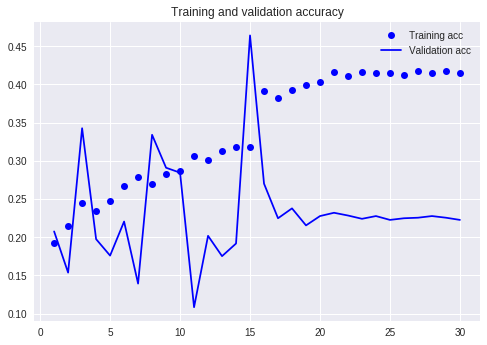

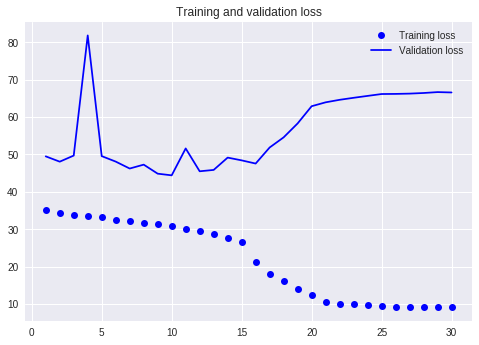

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Train with learning rate =0.001, and batch_size = 16 and Lr decay of 0.1 when loss plateaus each 5 epochs, minimum Lr = 0.00001

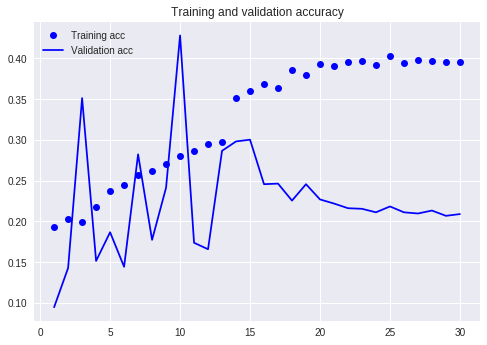

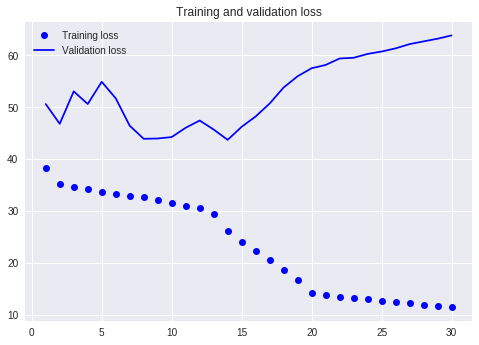

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Train with learning rate =0.001, and batch_size = 16


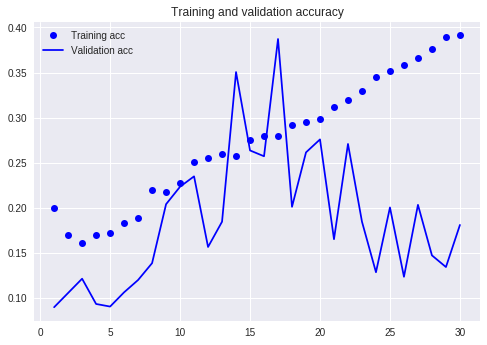

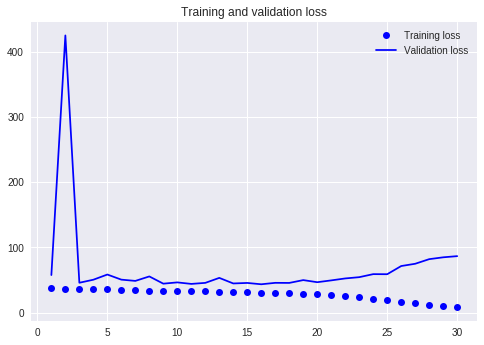

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Train with learning rate =0.01, and batch_size = 32

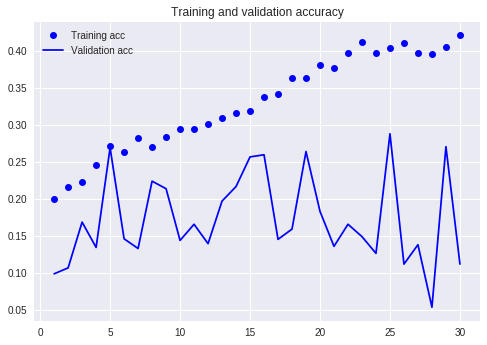

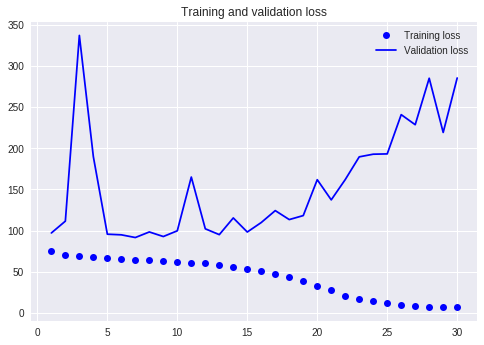

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
#ax.tick_params(axis='x', colors='black')
#ax.tick_params(axis='y', colors='black')
#ax.set_facecolor((1,1,1))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##Train with learning rate =0.0001, and batch_size = 16

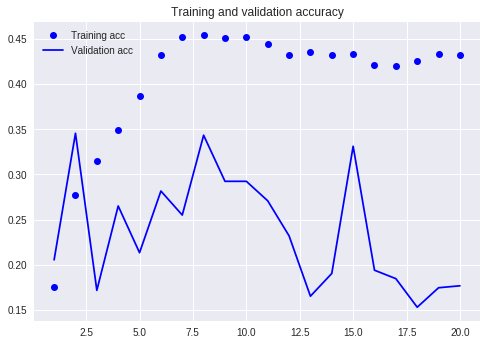

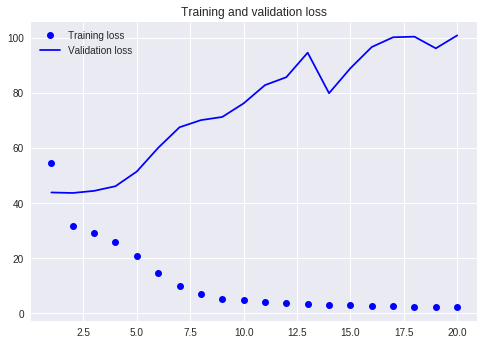

In [0]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
#ax.tick_params(axis='x', colors='black')
#ax.tick_params(axis='y', colors='black')
#ax.set_facecolor((1,1,1))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Observations 

-  The loss fucntion does not affect the results (AUC score per class)